In [1]:
# Imports
import sys
import os
import numpy as np
from pde import PDE, CartesianGrid, MemoryStorage, ScalarField
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath(os.path.join(os.path.abspath('..'),os.pardir))
sys.path.append(PROJECT_ROOT)

from electronTransportCode.SimulationDomain import SimulationDomain
from electronTransportCode.Material import unitDensityMaterial
from electronTransportCode.MCEstimator import FluenceEstimator, DoseEstimator, TrackEndEstimator
from electronTransportCode.ParticleModel import DiffusionTestParticle
from electronTransportCode.SimOptions import DiffusionPointSource
from electronTransportCode.MCParticleTracer import AnalogParticleTracer
%matplotlib widget


In [2]:
# Initialize Advection-Diffusion parameters 
stoppingPower = 1
scatteringRate1 = '(1 + 0.5*sin(x))'; scatteringRate1_dx = '(-0.5*cos(x)/((1 + 0.5*sin(x))**2))'
scatteringRate2 = '(100 + 10*sin(x))'; scatteringRate2_dx = '(cos(x)/(10*(10 + sin(x))**2))'
varH = 1/3  # 1 in 1D, 1/3 in 3D
sigmaInit = 1.0
muInit = 0.0

# Initialize simulation parameters
tmax = 1.0
xbins = 512
xmax = 15.0

# initialize the equation and the space
eq1 = PDE({"φ": f"laplace({varH}*φ/({stoppingPower}*{scatteringRate1})) - d_dx(φ*{varH}*{scatteringRate1_dx}/{stoppingPower})"})
eq2 = PDE({"φ": f"laplace({varH}*φ/({stoppingPower}*{scatteringRate2})) - d_dx(φ*{varH}*{scatteringRate2_dx}/{stoppingPower})"})

grid = CartesianGrid([(-xmax, xmax)], [xbins], periodic=True)
state = ScalarField.from_expression(grid, f"exp(-0.5*((x-{muInit})/{sigmaInit})**2)/({sigmaInit}*sqrt(2*{np.pi}))")

# solve the equation and store the trajectory
storage1 = MemoryStorage()
result1 = eq1.solve(state, t_range=tmax, tracker=storage1.tracker(1), dt=1e-5)

storage2 = MemoryStorage()
result2 = eq2.solve(state, t_range=tmax, tracker=storage2.tracker(1), dt=1e-5)

In [3]:
# Initialize Monte Carlo Algorithm

# Set up simulation domain
ymin = -xmax; ymax = xmax; ybins = 2
zmin = -xmax; zmax = xmax; zbins = 2
simDomain = SimulationDomain(ymin, ymax, zmin, zmax, ybins, zbins, material=unitDensityMaterial)

# Set up initial conditions
NB_PARTICLES = 30000
eSource: float = tmax
SEED: int = 4  # Random number generator seed
pointSourceSim = DiffusionPointSource(minEnergy=0.0, rngSeed=SEED, eSource=eSource, loc=muInit, std=sigmaInit)

# Scattering angle must be independent of previous angle!
DiffusionPointSource.SAMPLE_NEW_ABSOLUTE_DIRECTION = True  # type: ignore

# Set up estimator and particle
trackEndEstimatorx1 = TrackEndEstimator(simDomain, NB_PARTICLES, setting='x')
trackEndEstimatorx2 = TrackEndEstimator(simDomain, NB_PARTICLES, setting='x')

particle1 = DiffusionTestParticle(Es=scatteringRate1)
particle2 = DiffusionTestParticle(Es=scatteringRate2)

particleTracer1 = AnalogParticleTracer(particle=particle1, simOptions=pointSourceSim, simDomain=simDomain)
particleTracer2 = AnalogParticleTracer(particle=particle2, simOptions=pointSourceSim, simDomain=simDomain)

# Run simulation
particleTracer1(nbParticles=NB_PARTICLES, estimators=(trackEndEstimatorx1))

Last 1000 particles took 1.8014109260002442 seconds. 3.3333333333333335% completed.
Last 1000 particles took 0.17351873300140142 seconds. 6.666666666666667% completed.
Last 1000 particles took 0.18153913499918417 seconds. 10.0% completed.
Last 1000 particles took 0.1739549280027859 seconds. 13.333333333333334% completed.
Last 1000 particles took 0.17223082300188253 seconds. 16.666666666666668% completed.
Last 1000 particles took 0.17522557900156244 seconds. 20.0% completed.
Last 1000 particles took 0.17372209200038924 seconds. 23.333333333333332% completed.
Last 1000 particles took 0.17470602499815868 seconds. 26.666666666666668% completed.
Last 1000 particles took 0.17310333400018862 seconds. 30.0% completed.
Last 1000 particles took 0.1820443919968966 seconds. 33.333333333333336% completed.
Last 1000 particles took 0.17863264200059348 seconds. 36.666666666666664% completed.
Last 1000 particles took 0.17354561499814736 seconds. 40.0% completed.
Last 1000 particles took 0.1724078540028

In [4]:
particleTracer2(nbParticles=NB_PARTICLES, estimators=(trackEndEstimatorx2))

Last 1000 particles took 10.509955510002328 seconds. 3.3333333333333335% completed.
Last 1000 particles took 11.184311357999832 seconds. 6.666666666666667% completed.
Last 1000 particles took 10.524854418999894 seconds. 10.0% completed.
Last 1000 particles took 9.992443712999375 seconds. 13.333333333333334% completed.
Last 1000 particles took 9.919344166999508 seconds. 16.666666666666668% completed.
Last 1000 particles took 11.10218642000109 seconds. 20.0% completed.
Last 1000 particles took 10.915531044996897 seconds. 23.333333333333332% completed.
Last 1000 particles took 10.797541367999656 seconds. 26.666666666666668% completed.
Last 1000 particles took 10.790056112000457 seconds. 30.0% completed.
Last 1000 particles took 10.62653788100215 seconds. 33.333333333333336% completed.
Last 1000 particles took 10.470342786000401 seconds. 36.666666666666664% completed.
Last 1000 particles took 11.254776357000082 seconds. 40.0% completed.
Last 1000 particles took 10.805163364999316 seconds. 

Text(0.5, 0.98, 'Advection-Diffusion limit test')

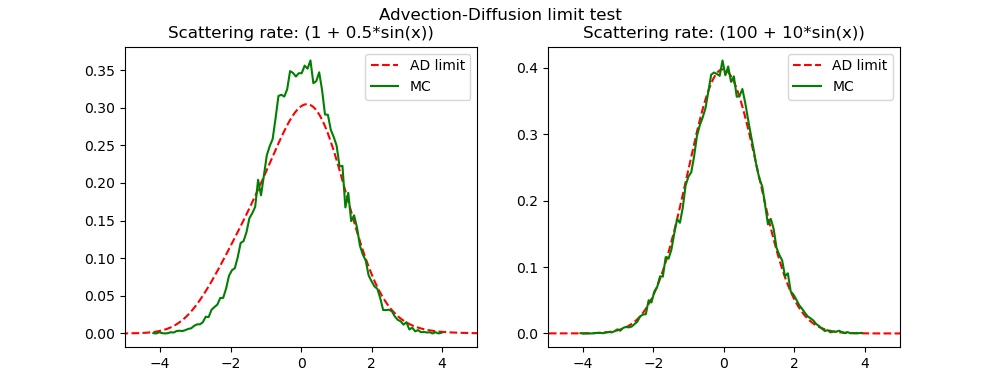

In [5]:
# Plot solutions

# Advection-diffusion solution 1
ADres1 = storage1.data[-1]
ADres2 = storage2.data[-1]
xres = np.linspace(-xmax, xmax, xbins, endpoint=False)

# MC solution 1
xdensity1 = trackEndEstimatorx1.scoreMatrix
binVal1, binEdge1 = np.histogram(xdensity1, bins=100, density=True)
binCenter1 = (binEdge1[:-1] + binEdge1[1:])/2.0

# MC solution 2
xdensity2 = trackEndEstimatorx2.scoreMatrix
binVal2, binEdge2 = np.histogram(xdensity2, bins=100, density=True)
binCenter2 = (binEdge2[:-1] + binEdge2[1:])/2.0

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.9))
ax1.plot(xres, ADres1, 'r--', label=f'AD limit')
ax1.plot(binCenter1, binVal1, 'g', label=f'MC')
ax1.set_xlim((-5, 5))
ax1.legend()
ax1.set_title(f'Scattering rate: {scatteringRate1}')

ax2.plot(xres, ADres2, 'r--', label=f'AD limit')
ax2.plot(binCenter2, binVal2, 'g', label=f'MC')
ax2.set_xlim((-5, 5))
ax2.legend()
ax2.set_title(f'Scattering rate: {scatteringRate2}')

fig.suptitle('Advection-Diffusion limit test')